<a href="https://colab.research.google.com/github/juhi2811/DeepFashion/blob/df_v1/Multi_output_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [1]:
!pip install tensorflow-estimator==2.1.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 5.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.1.0 which is incompatible.


In [2]:
!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install colorthief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import modules

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from colorthief import ColorThief
import scipy
from scipy.spatial import KDTree
from webcolors import CSS3_HEX_TO_NAMES,hex_to_rgb
from PIL import Image, ImageFont, ImageDraw
import random
import pathlib
import os
import cv2

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Mount Google drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.chdir("gdrive")#/Colab Notebooks/DeepFashionCode")

In [5]:
os.listdir()

['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0']

In [6]:
df_images=pd.DataFrame(columns=["image_folder","image_name"])


Read images into a dataframe

In [7]:
folders_images=["MyDrive/img/"+f for f in os.listdir("MyDrive/img") if "." not in f]

In [8]:
for l in folders_images:
  if len(l)>0:
    df_append=pd.DataFrame(columns=["image_folder","image_path"])
    df_append["image_folder"]=[l for idx in range(len(os.listdir(l)))]
    df_append["image_name"]=os.listdir(l)
    df_images=df_images.append(df_append,ignore_index=True)

In [9]:
df_images["image_path"]=df_images["image_folder"]+"/"+df_images["image_name"]

In [10]:
df_images["item_class"]=df_images["image_path"].apply(lambda x: x.split("/")[-2].split("_")[-1])
df_images["design_class"]=df_images["image_path"].apply(lambda x: x.split("/")[-2].split("_")[-2])
df_images["design_pre"]=df_images["image_path"].apply(lambda x: [x.split("/")[-2].split("_")[-3] if len(x.split("/")[-2].split("_"))>3 else ""][0])
df_images["design_type"]=df_images["design_pre"]+" "+df_images["design_class"]

img_00000008.jpg


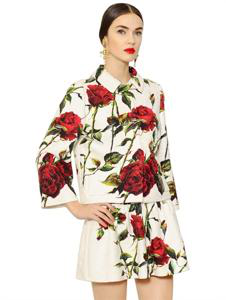

In [11]:
print(list(df_images[df_images["item_class"]=="Blouse"]["image_path"])[1].split("/")[3])
PIL.Image.open(list(df_images[df_images["design_type"].str.contains("Rose")]["image_path"])[34])

In [12]:
from google.colab import files
#import preprocess_images
!cp /content/drive/MyDrive/ColabNotebooks/DeepFashionCode/preprocess_images.py

cp: missing destination file operand after '/content/drive/MyDrive/ColabNotebooks/DeepFashionCode/preprocess_images.py'
Try 'cp --help' for more information.


Preprocessing images

In [13]:

def convert_rgb_to_names(rgb_tuple):
  """Convert rgb tuples to color name"""
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return f'closest match: {names[index]}'

  def preprocess_resize(df):
    """Preprocess and resize images to create RGB array of pixels"""
    df["content"] = df["image_path"].apply(lambda x: cv2.imread(x))

    df["image_resized"] = df["content"].apply(lambda x: np.array(cv2.resize(x, (32,32))))
      # Resize the image to the desired size
    #df["image_resized"] = df["image_raw"].apply(lambda x: tf.image.resize(x, [img_height, img_width]))
    return df

IndentationError: ignored

In [ ]:
color_thief = ColorThief(list(df_images[df_images["item_class"]=="Hoodie"]["image_path"])[2])
# get the dominant color
dominant_color = color_thief.get_color(quality=1)
closest_dominant_name=convert_rgb_to_names(dominant_color)
closest_dominant_name

Create category mapping for different attributes

In [ ]:
tops=['Cardigan', 'Tee', 'Top', 'Sweater', 'Halter',
       'Tank', 'Hoodie', 'Blazer', 'Jacket',
       'Blouse', 'Coat', 
        'Button-Down','Turtleneck', 'Kaftan', 'Flannel',
       'Parka', 'Henley', 'Poncho', 'Jersey',
       'Anorak', 'Jodhpurs', 'Caftan']
bottoms=['Skirt', 'Leggings', 'Sweatpants', 
       'Shorts', 'Jeans', 'Joggers',   'Chinos',
       'Cutoffs', 'Culottes', 
       'Jeggings', 'Sweatshorts', 'Capris', 'Trunks',
       'Gauchos']
one_pieces=['Dress',
       'Kimono', 'Jumpsuit', 'Coverup', 'Robe', 'Onesie','Romper']
formals=['Blazer','Blouse','Jumpsuit','Turtleneck','Skirt','Dress','Coat','Chinos']
casuals=[ 'Tee', 'Top', 'Sweater', 'Halter',   'Jacket',
        'Button-Down','Kaftan', 'Flannel',
       'Parka', 'Henley', 'Poncho','Anorak', 'Jodhpurs', 'Caftan','Leggings','Sweatpants', 
       'Shorts', 'Jeans', 
       'Cutoffs', 'Culottes', 
       'Jeggings', 'Sweatshorts', 'Capris', 'Trunks',
       'Gauchos','Kimono','Onesie','Coverup','Romper']
# spring=["Dress","Jumpsuit","Skirt"]
sporty=['Hoodie','Tank','Jersey','Joggers',  'Hoodie']
df_images["dress_type"]=df_images["item_class"].apply(lambda x: ["top" if x in tops else "bottom" if x in bottoms else "one_piece"][0])
df_images["dress_ocassion"]=df_images["item_class"].apply(lambda x: ["sporty" if x in sporty else "formal" if x in formals else "casual"][0])
df_images["broad_design"]=df_images["design_type"].apply(lambda x: ["Print" if ("print" in x.lower() or "floral" in x.lower() or "dot" in x.lower() or "tulip" in x.lower() or "stripe" in x.lower() or "boxy" in x.lower() or "tulip" in x.lower() or "rose" in x.lower()) else "Knit" if ("knit" in x.lower()  or "embroidere" in x.lower() or "woven" in x.lower() or "crochet" in x.lower() or "texture" in x.lower()) else "Classic"][0])

In [21]:
df_images["print_type"]=df_images["design_type"].apply(lambda x: ["Dotted" if ("dot" in x.lower() or "spot" in x.lower()) else "Floral" if  ("floral" in x.lower() or "rose" in x.lower()) else "Striped" if ("stripe" in x.lower() and "lined" in x.lower()) else "Boxed"  if "boxy" in x.lower() else "Graphic" if "graphic" in x.lower() else "NA"][0])
df_images["print_type"]=df_images.apply(lambda dfx: ["Other prints" if (dfx["broad_design"]=="Print" and dfx["print_type"]=="NA") else dfx["print_type"]][0],axis=1)

In [22]:
df_images["print_type"].unique()

array(['NA', 'Other prints', 'Floral', 'Dotted', 'Graphic', 'Boxed'],
      dtype=object)

In [24]:
df_images.groupby("dress_type").count()

,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_ocassion,broad_design,print_type
dress_type,,,,,,,,,,
bottom,32655,32655,32655,32655,32655,32655,32655,32655,32655,32655
one_piece,51329,51329,51329,51329,51329,51329,51329,51329,51329,51329
top,81883,81883,81883,81883,81883,81883,81883,81883,81883,81883


In [25]:
df_images.groupby("dress_ocassion").count()

,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_type,broad_design,print_type
dress_ocassion,,,,,,,,,,
casual,75867,75867,75867,75867,75867,75867,75867,75867,75867,75867
formal,75457,75457,75457,75457,75457,75457,75457,75457,75457,75457
sporty,14543,14543,14543,14543,14543,14543,14543,14543,14543,14543


In [ ]:
df_images.groupby("broad_design").count()

,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_type,dress_ocassion,print_type
broad_design,,,,,,,,,,
Classic,115157,115157,115157,115157,115157,115157,115157,115157,115157,115157
Knit,15707,15707,15707,15707,15707,15707,15707,15707,15707,15707
Print,35003,35003,35003,35003,35003,35003,35003,35003,35003,35003


In [26]:
###Sampling for equal number of samples per design 
df_images_rel_des=pd.DataFrame()
for dt in df_images["broad_design"].unique():
  df_append=df_images[df_images["broad_design"]==dt].sample(n=15000, replace=True, random_state=44)
  df_images_rel_des=df_images_rel_des.append(df_append,ignore_index=True)
df_images_rel_des

,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_type,dress_ocassion,broad_design,print_type
0,MyDrive/img/Classic_Pullover_Hoodie,img_00000054.jpg,MyDrive/img/Classic_Pullover_Hoodie/img_000000...,Hoodie,Pullover,,Pullover,top,sporty,Classic,NA
1,MyDrive/img/Striped_V-Neck_Cotton_Tee,img_00000032.jpg,MyDrive/img/Striped_V-Neck_Cotton_Tee/img_0000...,Tee,Cotton,V-Neck,V-Neck Cotton,top,casual,Classic,NA
2,MyDrive/img/Striped_Cami_Jumpsuit,img_00000009.jpg,MyDrive/img/Striped_Cami_Jumpsuit/img_00000009...,Jumpsuit,Cami,,Cami,one_piece,formal,Classic,NA
3,MyDrive/img/Denim_Skater_Skirt,img_00000065.jpg,MyDrive/img/Denim_Skater_Skirt/img_00000065.jpg,Skirt,Skater,,Skater,bottom,formal,Classic,NA
4,MyDrive/img/Floral_Chiffon_Blouse,img_00000095.jpg,MyDrive/img/Floral_Chiffon_Blouse/img_00000095...,Blouse,Chiffon,,Chiffon,top,formal,Classic,NA
...,...,...,...,...,...,...,...,...,...,...,...
44995,MyDrive/img/Boxy_Soft-Knit_Sweater,img_00000035.jpg,MyDrive/img/Boxy_Soft-Knit_Sweater/img_0000003...,Sweater,Soft-Knit,,Soft-Knit,top,casual,Knit,NA
44996,MyDrive/img/Heathered_Knit_Coat,img_00000023.jpg,MyDrive/img/Heathered_Knit_Coat/img_00000023.jpg,Coat,Knit,,Knit,top,formal,Knit,NA
44997,MyDrive/img/Striped_Knit_Sweater,img_00000011.jpg,MyDrive/img/Striped_Knit_Sweater/img_00000011.jpg,Sweater,Knit,,Knit,top,casual,Knit,NA
44998,MyDrive/img/High-Waisted_Woven_Shorts,img_00000002.jpg,MyDrive/img/High-Waisted_Woven_Shorts/img_0000...,Shorts,Woven,,Woven,bottom,casual,Knit,NA


In [27]:
###Sampling for equal number of samples per dress type 
df_images_rel=pd.DataFrame()
for dt in df_images["dress_type"].unique():
  df_append=df_images_rel_des[df_images_rel_des["dress_type"]==dt].sample(n=8000, replace=True, random_state=33)
  df_images_rel=df_images_rel.append(df_append,ignore_index=True)
df_images_rel

,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_type,dress_ocassion,broad_design,print_type
0,MyDrive/img/Free_Spirit_Floral_Maxi_Dress,img_00000046.jpg,MyDrive/img/Free_Spirit_Floral_Maxi_Dress/img_...,Dress,Maxi,Floral,Floral Maxi,one_piece,formal,Print,Floral
1,MyDrive/img/Sequined_Chiffon_Maxi_Dress,img_00000048.jpg,MyDrive/img/Sequined_Chiffon_Maxi_Dress/img_00...,Dress,Maxi,Chiffon,Chiffon Maxi,one_piece,formal,Classic,NA
2,MyDrive/img/Belted_Tribal_Print_Maxi_Dress,img_00000019.jpg,MyDrive/img/Belted_Tribal_Print_Maxi_Dress/img...,Dress,Maxi,Print,Print Maxi,one_piece,formal,Print,Other prints
3,MyDrive/img/Crisscross-Back_Skater_Dress,img_00000006.jpg,MyDrive/img/Crisscross-Back_Skater_Dress/img_0...,Dress,Skater,,Skater,one_piece,formal,Classic,NA
4,MyDrive/img/Floral_Crochet_Racerback_Romper,img_00000024.jpg,MyDrive/img/Floral_Crochet_Racerback_Romper/im...,Romper,Racerback,Crochet,Crochet Racerback,one_piece,casual,Knit,NA
...,...,...,...,...,...,...,...,...,...,...,...
23995,MyDrive/img/High-Waisted_Capri_Leggings,img_00000024.jpg,MyDrive/img/High-Waisted_Capri_Leggings/img_00...,Leggings,Capri,,Capri,bottom,casual,Classic,NA
23996,MyDrive/img/Textured_Woven_Shorts,img_00000017.jpg,MyDrive/img/Textured_Woven_Shorts/img_00000017...,Shorts,Woven,,Woven,bottom,casual,Knit,NA
23997,MyDrive/img/Diamond_Embroidered_Shorts,img_00000035.jpg,MyDrive/img/Diamond_Embroidered_Shorts/img_000...,Shorts,Embroidered,,Embroidered,bottom,casual,Knit,NA
23998,MyDrive/img/Bleached_Denim_Joggers,img_00000058.jpg,MyDrive/img/Bleached_Denim_Joggers/img_0000005...,Joggers,Denim,,Denim,bottom,sporty,Classic,NA


Declare image variables

In [30]:
batch_size = 32
img_height = 32
img_width = 32

In [33]:
os.listdir()

['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0']

**Create models**

Cloth categorizer

In [34]:
dense = layers.Dense(64, activation="relu")
inputs = keras.Input(shape=(32*32*3,))
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs1 = layers.Dense(3,activation="softmax")(x)
outputs2 = layers.Dense(3,activation="softmax")(x)
outputs3 = layers.Dense(3,activation="softmax")(x)

model_multi = keras.Model(inputs=inputs, outputs=[outputs1,outputs2,outputs3], name="cloth_design_categorizer")
model = keras.Model(inputs=inputs, outputs=outputs1, name="cloth_categorizer")


Print categorizer

In [35]:
dense = layers.Dense(64, activation="relu")
inputs = keras.Input(shape=(32*32*3,))
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)

model_print = keras.Model(inputs=inputs, outputs=outputs, name="cloth_print_categorizer")


In [2]:
len(df_images_rel)

NameError: ignored

**Preprocessing images**

In [ ]:
df_images_preprocessed=pd.DataFrame()
idx=0
for idx in range(idx,len(df_images_rel),5000):
  if idx+5000<len(df_images_rel):
    print("if", idx)
    df_images_preprocessed_sub=preprocess_resize(df_images_rel[idx:idx+5000])
    df_images_preprocessed=df_images_preprocessed.append(df_images_preprocessed_sub,ignore_index=True)
    idx=idx+5000
  elif idx==len(df_images_rel):
    print("elif", idx)
    df_images_preprocessed=df_images_preprocessed
  else:
    print("else", idx)
    print("now last few idx:",idx)
    df_images_preprocessed_sub=preprocess_resize(df_images_rel[idx:])
    df_images_preprocessed=df_images_preprocessed.append(df_images_preprocessed_sub,ignore_index=True)
    idx=idx+5000

  #df_images_preprocessed["image_resized"]

if 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


if 5000
if 10000
if 15000


In [ ]:
###One time export
from google.colab import drive

# drive.mount('/content/drive')
path = 'My Drive/Colab Noteboooks/Preprocessed_images.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_images_preprocessed.to_csv(f)

# df_images_preprocessed.to_csv("Preprocessed_images.csv")

Save preprocessed images

In [ ]:
path = 'My Drive/Preprocessed_images.csv'
import ast
import numpy as np
def from_np_array(array_string):
    array_string = ','.join(array_string.replace("\n","").replace('[ ', '[').split())
    #print(array_string)
    return array_string
    # return np.array(ast.literal_eval(array_string))

In [59]:
df_in=pd.read_csv(path)
df_in.head()

,Unnamed: 0,image_folder,image_name,image_path,item_class,design_class,design_pre,design_type,dress_type,dress_ocassion,broad_design,print_type,content,image_resized,dress_type_num,broad_design_num,dress_occasion_num
0,0,MyDrive/img/Free_Spirit_Floral_Maxi_Dress,img_00000046.jpg,MyDrive/img/Free_Spirit_Floral_Maxi_Dress/img_...,Dress,Maxi,Floral,Floral Maxi,one_piece,formal,Print,Floral,[[[242 242 242]\n [242 242 242]\n [242 242 2...,[[[242 242 242] [242 242 242] [242 242 242] ...,2,0,0
1,1,MyDrive/img/Sequined_Chiffon_Maxi_Dress,img_00000048.jpg,MyDrive/img/Sequined_Chiffon_Maxi_Dress/img_00...,Dress,Maxi,Chiffon,Chiffon Maxi,one_piece,formal,Classic,NaN,[[[176 155 154]\n [176 155 154]\n [175 154 1...,[[[175 155 153] [176 156 154] [172 153 150] ...,2,2,0
2,2,MyDrive/img/Belted_Tribal_Print_Maxi_Dress,img_00000019.jpg,MyDrive/img/Belted_Tribal_Print_Maxi_Dress/img...,Dress,Maxi,Print,Print Maxi,one_piece,formal,Print,Other prints,[[[255 255 255]\n [255 255 255]\n [255 255 2...,[[[255 255 255] [255 255 255] [255 255 255] ...,2,0,0
3,3,MyDrive/img/Crisscross-Back_Skater_Dress,img_00000006.jpg,MyDrive/img/Crisscross-Back_Skater_Dress/img_0...,Dress,Skater,NaN,Skater,one_piece,formal,Classic,NaN,[[[255 255 255]\n [255 255 255]\n [255 255 2...,[[[255 255 255] [255 255 255] [255 255 255] ...,2,2,0
4,4,MyDrive/img/Floral_Crochet_Racerback_Romper,img_00000024.jpg,MyDrive/img/Floral_Crochet_Racerback_Romper/im...,Romper,Racerback,Crochet,Crochet Racerback,one_piece,casual,Knit,NaN,[[[255 255 255]\n [255 255 255]\n [255 255 2...,[[[255 255 255] [255 255 255] [255 255 255] ...,2,1,1


In [64]:
# df_in["image_resized"]=df_in["image_resized"].apply(lambda x: np.array(ast.literal_eval(x.replace('[ ', '[').replace(' ', ',').replace(',,', '').replace('..', ''))))
#new_df['array_col'] = new_df['sample'].apply(lambda x: np.array(literal_eval(x.replace('[ ', '[').replace(' ', ','))))


SyntaxError: ignored

In [ ]:
# df_in["image_resized"]=df_in["image_resized"].apply(lambda x: np.fromstring(x, sep='\n'))
# df_images_preprocessed=df_in.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  """Entry point for launching an IPython kernel.


Training sets: Multi **model**

In [41]:
X=df_images_preprocessed["image_resized"].array
X=np.asarray(list(X)).astype(np.float32)
df_images_preprocessed["dress_type_num"]=df_images_preprocessed["dress_type"].replace(["top","bottom","one_piece"],[0,1,2])
df_images_preprocessed["broad_design_num"]=df_images_preprocessed["broad_design"].replace(["Print","Knit","Classic"],[0,1,2])
df_images_preprocessed["dress_occasion_num"]=df_images_preprocessed["dress_ocassion"].replace(["formal","casual","sporty"],[0,1,2])

y=df_images_preprocessed[["dress_type_num","broad_design_num","dress_occasion_num"]]

y_1=to_categorical(y["dress_type_num"])

y_2=to_categorical(y["broad_design_num"])

y_3=to_categorical(y["dress_occasion_num"])

In [42]:
len(X)

24000

raining sets: Print model 2

In [43]:
df_images_prep_model2=df_images_preprocessed[df_images_preprocessed["broad_design"]=="Print"]
X_p=df_images_prep_model2["image_resized"].array
X_p=np.asarray(list(X_p)).astype(np.float32)
#'Other prints', 'Floral', 'Dotted', 'Graphic', 'Boxed'
df_images_prep_model2["print_type_num"]=df_images_prep_model2["print_type"].replace(['Floral', 'Dotted', 'Graphic', 'Boxed','Other prints'],[0,1,2,3,4])

y_p=df_images_prep_model2[["print_type_num"]]

y_p1=to_categorical(y_p["print_type_num"])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [44]:
model_multi.summary()

Model: "cloth_design_categorizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3072)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           196672      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           4160        ['dense_1[0][0]']                
                                                                           

In [45]:
model_print.summary()

Model: "cloth_print_categorizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_7 (Dense)             (None, 64)                196672    
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 209,477
Trainable params: 209

Save architecture diagrams

In [ ]:
keras.utils.plot_model(model_multi, "MyDrive/my_first_model.png")
keras.utils.plot_model(model_print, "MyDrive/My_print_model.png")

In [46]:
X.shape,y_1.shape,y_2.shape,y_3.shape

((24000, 32, 32, 3), (24000, 3), (24000, 3), (24000, 3))

**Train models**

Train multioutput model

In [47]:
x = X.reshape(len(X), 32*32*3).astype(np.float32) / 255

model_multi.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(),
    metrics=["accuracy"],
)

history = model_multi.fit(x, [y_1,y_2,y_3], batch_size=32, epochs=100, validation_split=0.25)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


563/563 [==============================] - 7s 8ms/step - loss: 2.9227 - dense_4_loss: 0.9249 - dense_5_loss: 1.1012 - dense_6_loss: 0.8966 - dense_4_accuracy: 0.5442 - dense_5_accuracy: 0.3479 - dense_6_accuracy: 0.5445 - val_loss: 4.4174 - val_dense_4_loss: 2.2864 - val_dense_5_loss: 1.0985 - val_dense_6_loss: 1.0325 - val_dense_4_accuracy: 0.0000e+00 - val_dense_5_accuracy: 0.3975 - val_dense_6_accuracy: 0.3417
Epoch 2/100
563/563 [==============================] - 3s 5ms/step - loss: 2.8273 - dense_4_loss: 0.8635 - dense_5_loss: 1.0947 - dense_6_loss: 0.8691 - dense_4_accuracy: 0.5943 - dense_5_accuracy: 0.3649 - dense_6_accuracy: 0.5759 - val_loss: 4.1729 - val_dense_4_loss: 1.9587 - val_dense_5_loss: 1.0844 - val_dense_6_loss: 1.1298 - val_dense_4_accuracy: 0.0122 - val_dense_5_accuracy: 0.3940 - val_dense_6_accuracy: 0.3282
Epoch 3/100
563/563 [==============================] - 3s 5ms/step - loss: 2.7787 - dense_4_loss: 0.8313 - dense_5_loss: 1.0926 - dense_6_loss: 0.8548 - dense

Predicting the multi- labels from multi output model

In [ ]:
# ##Testing the model

In [48]:
df_validation=df_images[~df_images["image_path"].isin(df_images_rel["image_path"].unique())].sample(n=2000)
df_validation=preprocess_resize(df_validation)

In [49]:
X_val=df_validation["image_resized"].array
X_val=np.asarray(list(X_val)).astype(np.float32)
X_val=X_val.reshape(len(X_val), 32*32*3).astype(np.float32) / 255
df_validation["dress_type_num"]=df_validation["dress_type"].replace(["top","bottom","one_piece"],[0,1,2])
df_validation["broad_design_num"]=df_validation["broad_design"].replace(["Print","Knit","Classic"],[0,1,2])
df_validation["dress_occasion_num"]=df_validation["dress_ocassion"].replace(["formal","casual","sporty"],[0,1,2])

y_val1=df_validation["dress_type_num"]
y_val2=df_validation["broad_design_num"]
y_val3=df_validation["dress_occasion_num"]

In [50]:
predictions = model_multi.predict(X_val)

In [52]:
[argmax(to_categorical(x, k))) for x in predictions]

SyntaxError: ignored

In [ ]:

# X_val=df_validation["image_resized"].array
# X_val=np.asarray(list(X_val)).astype(np.float32)
# X_val=X_val.reshape(len(X_val), 32*32*3).astype(np.float32) / 255
# df_validation["dress_type_num"]=df_validation["dress_type"].replace(["top","bottom","one_piece"],[0,1,2])
# df_validation["broad_design_num"]=df_validation["broad_design"].replace(["Print","Knit","Classic"],[0,1,2])

# y_val1=np.array(df_validation["dress_type_num"])
# y_val2=np.array(df_images_preprocessed["broad_design_num"])
# y_predict=model_multi.predict(X_val)


In [53]:
y_predict1=predictions[0]
y_predict_val1=np.array([list(y).index(max(list(y))) for y in list(y_predict1)])
##argmax(to_categorical(x, k)))

y_predict2=predictions[1]
y_predict_val2=np.array([list(y).index(max(list(y))) for y in list(y_predict2)])


y_predict3=predictions[2]
y_predict_val3=np.array([list(y).index(max(list(y))) for y in list(y_predict3)])

df_validation["y_predict_val1"]=y_predict_val1
df_validation["y_predict_val2"]=y_predict_val2
df_validation["y_predict_val3"]=y_predict_val3

df_validation["y_predict_val_dress_type"]=df_validation["y_predict_val1"].replace([0,1,2],["top","bottom","one_piece"])
df_validation["y_predict_val_broad_design"]=df_validation["y_predict_val2"].replace([0,1,2],["Print","Knit","Classic"])
df_validation["y_predict_val_dress_occassion"]=df_validation["y_predict_val3"].replace([0,1,2],["formal","casual","sporty"])


Next part of the model: if broad_design: Print

Train print model

In [54]:
x_p = X_p.reshape(len(X_p), 32*32*3).astype(np.float32) / 255
model_print.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(),
    metrics=["accuracy"],
)

history = model_print.fit(x_p, y_p1, batch_size=32, epochs=100, validation_split=0.25)

Epoch 1/100
202/202 [==============================] - 3s 9ms/step - loss: 0.7947 - accuracy: 0.7360 - val_loss: 0.8791 - val_accuracy: 0.6866
Epoch 2/100
202/202 [==============================] - 2s 8ms/step - loss: 0.7775 - accuracy: 0.7393 - val_loss: 0.8989 - val_accuracy: 0.6866
Epoch 3/100
202/202 [==============================] - 2s 8ms/step - loss: 0.7704 - accuracy: 0.7393 - val_loss: 0.8882 - val_accuracy: 0.6866
Epoch 4/100
202/202 [==============================] - 2s 8ms/step - loss: 0.7681 - accuracy: 0.7393 - val_loss: 0.8630 - val_accuracy: 0.6866
Epoch 5/100
202/202 [==============================] - 2s 8ms/step - loss: 0.7665 - accuracy: 0.7393 - val_loss: 0.8826 - val_accuracy: 0.6866
Epoch 6/100
202/202 [==============================] - 2s 9ms/step - loss: 0.7638 - accuracy: 0.7393 - val_loss: 0.8862 - val_accuracy: 0.6866
Epoch 7/100
202/202 [==============================] - 2s 9ms/step - loss: 0.7629 - accuracy: 0.7393 - val_loss: 0.8621 - val_accuracy: 0.6866

Save model to Google drive

In [55]:
model_multi.save("MyDrive/Multi_output_cloth_model.h5")
model_print.save("MyDrive/Print_predictor_model.h5")


In [69]:
np.array([2,3,4]).tolist()

[2, 3, 4]

In [ ]:
df_images_preprocessed["image_resized_list"]=df_images_preprocessed["image_resized"].apply(lambda x: x.tolist())
df_images_preprocessed.to_csv('MyDrive/Preprocessed_images.csv')


Evaluation: Multi model

In [ ]:
####Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_predict_val1,y_val1),accuracy_score(y_predict_val2,y_val2),accuracy_score(y_predict_val3,y_val3)

(0.29, 0.136, 0.29)

In [ ]:
confusion_matrix(df_validation["dress_type"],df_validation["y_predict_val_dress_type"])

array([[351, 124,  58],
       [125, 502,  54],
       [190, 209, 387]])

Text(33.0, 0.5, 'Predicted')

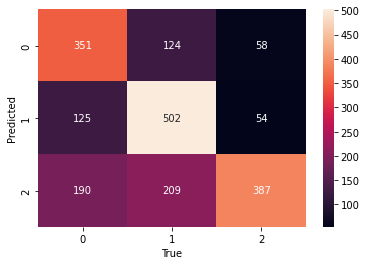

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(df_validation["dress_type"],df_validation["y_predict_val_dress_type"]), annot=True,fmt='.3g')
plt.xlabel('True') # x-axis label with fontsize 15
plt.ylabel('Predicted')#, fontsize = 15)

In [ ]:
sns.heatmap(confusion_matrix(df_validation["dress_ocassion"],df_validation["y_predict_val_dress_occassion"]), annot=True, fmt='.3g')
plt.xlabel('True') # x-axis label with fontsize 15
plt.ylabel('Predicted')


In [ ]:
sns.heatmap(confusion_matrix(df_validation["broad_design"],df_validation["y_predict_val_broad_design"]), annot=True, fmt='.3g')
plt.xlabel('True') # x-axis label with fontsize 15
plt.ylabel('Predicted')


In [ ]:
##Show result
n=np.random.randint(2000)
print("Predicted label: "+list(df_validation["y_predict_val_dress_type"])[n]+" while real label: "+list(df_validation["dress_type"])[n])
print("--------------------------------------------------------------------------------------------------------------------------------------")

print("Predicted label: "+list(df_validation["y_predict_val_dress_occassion"])[n]+" while real label: "+list(df_validation["dress_ocassion"])[n])
print("--------------------------------------------------------------------------------------------------------------------------------------")
print("Predicted label: "+list(df_validation["y_predict_val_broad_design"])[n]+" while real label: "+list(df_validation["broad_design"])[n],"Full name: "+list(df_validation["image_path"])[n].split("/")[3])
print("--------------------------------------------------------------------------------------------------------------------------------------")

PIL.Image.open(list(df_validation["image_path"])[n])


In [ ]:
PIL.Image.open(list(df_validation[df_validation["y_predict_val_broad_design"]=="Striped"]["image_path"])[4])


IndexError: ignored

Evaluation: Print model

In [ ]:
df_validation_print=df_validation[df_validation["y_predict_val_broad_design"]=="Print"]
X_val_p=df_validation_print["image_resized"].array
X_val_p=np.asarray(list(X_val_p)).astype(np.float32)
X_val_p=X_val_p.reshape(len(X_val_p), 32*32*3).astype(np.float32) / 255
df_validation_print["print_type_num"]=df_validation_print["print_type"].replace(['Floral', 'Dotted', 'Graphic', 'Boxed','Other prints'],[0,1,2,3,4])

y_valp1=df_validation_print["print_type_num"]
y_predict_p=model_print.predict(X_val_p)



In [ ]:
y_predict1_p=y_predict_p
y_predict_val1_p=np.array([list(y).index(max(list(y))) for y in list(y_predict1_p)])
df_validation_print["y_predict_val_p"]=y_predict_val1_p
df_validation_print["y_predict_val_print_type"]=df_validation_print["y_predict_val_p"].replace([0,1,2,3,4],['Floral', 'Dotted', 'Graphic', 'Boxed','Other prints'])

In [ ]:
accuracy_score(y_predict_val1_p,y_valp1.replace("NA",5))#,accuracy_score(y_predict_val2,y_val2),accuracy_score(y_predict_val3,y_val3)